In [1]:
import sys
import warnings
import os
import time
from glob import glob
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colorbar as mpl_colorbar
import seaborn as sns
from nilearn.glm import compute_fixed_effects
from nilearn.glm.second_level import SecondLevelModel
from nilearn import image, masking, plotting
from nilearn.datasets import fetch_atlas_difumo
from nilearn.maskers import NiftiMapsMasker
import warnings
from matplotlib import MatplotlibDeprecationWarning
%load_ext rpy2.ipython
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging

# Suppress R output
rpy2_logger.setLevel(logging.ERROR)

# Activate automatic conversion for pandas DataFrames
pandas2ri.activate()

# Load necessary R libraries
utils = importr('utils')
base = importr('base')

# Set CRAN mirror and install packages silently
utils.chooseCRANmirror(ind=1)
utils.install_packages('psych', quiet=True)
utils.install_packages('ggplot2', quiet=True)
utils.install_packages('paran', quiet=True)

# Import the installed libraries
psych = importr('psych')
ggplot2 = importr('ggplot2')

In [3]:
def plot_loading_phi(fa_object, title_name, out_img_path, out_type = 'phi', phi_plot_diag=True, row_labs=None):
    n_factors = np.array(fa_object.rx2('loadings')).shape[-1]

    if out_type == 'phi':
        sns.heatmap(fa_object.rx2('Phi'), annot=True, cmap='coolwarm', 
                    mask=np.triu(np.ones_like(fa_object.rx2('Phi'), dtype=bool), k = 1 if phi_plot_diag else 0),
                    vmin=-1, vmax=1, fmt='.2f', linewidths=0.25,
                    xticklabels=[f'{i+1}' for i in range(n_factors)], 
                    yticklabels=[f'{i+1}' for i in range(n_factors)])
        plt.title(f"{title_name}: Phi Matrix", fontsize=12)
        plt.xlabel("")
        plt.ylabel("")
    elif out_type == 'loadings':
        factor_loadings = fa_object.rx2('loadings')  
        factor_loadings[factor_loadings < 0.30] = np.nan
        no_id_labels = [label.replace(f"{title_name}_", "") for label in row_labs]
        df_loadings = pd.DataFrame(factor_loadings, 
                           columns=[f'Factor {i+1}' for i in range(factor_loadings.shape[1])],
                           index=no_id_labels)  # Set the row names to df.columns w/o the prefix ID lab
        plt.figure(figsize=(10, 8))
        sns.heatmap(df_loadings, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.25)
        plt.title(f"{title_name}: EFA Loadings", fontsize=12)
        plt.xlabel("Factors", fontsize=10)
        plt.ylabel("Contrasts", fontsize=10)
        
    
    plt.tick_params(axis='both', labelsize=8) 
    plt.savefig(out_img_path, bbox_inches='tight')
    plt.show()



def plot_fa_parallel(out, title_name, out_img_path):
    """
    Plots the results from the fa.parallel function from the psych package.
    
    Parameters:
        out (list): The output from the fa.parallel function containing the eigenvalues 
                    and simulated values for factor analysis and principal components.
                    
    Returns:
        None
    """

    # FA data eigen + sim eigen
    plt.plot(range(1, len(out[0]) + 1), out[0], label='FA EVs', color='black', marker='o', linestyle='-', markersize=3)
    plt.plot(range(1, len(out[0]) + 1), out[4], label='FA Sim EVs', color='black', marker='x', linestyle='--', markersize=3)

    # PC data eigen + sim eigen
    plt.plot(range(1, len(out[0]) + 1), out[1], label='PC EVs', color='red', marker='o', linestyle='-', markersize=3)
    plt.plot(range(1, len(out[0]) + 1), out[2], label='PC Sim EVs', color='red', marker='x', linestyle='--', markersize=3)

    # factors/components
    recommended_factors = int(out[6])
    recommended_components = int(out[7])
    
    plt.axvline(x=recommended_factors, color='blue', linestyle=':', label=f'Rec Facts: ({recommended_factors})')
    plt.axvline(x=recommended_components, color='green', linestyle=':', label=f'Rec Comp: ({recommended_components})')

    plt.xlabel('')
    plt.ylabel('Eigenvalue')
    plt.title(f'{title_name}: Parallel Analysis Eigenvalues')
    plt.legend(loc='best')
    plt.grid(True)
    plt.figtext(0.95, 0.02, "Note: PC EVs is used in Scree plots eigen > 1", ha='right', fontsize=8, color='black')
    plt.savefig(out_img_path, bbox_inches='tight')
    plt.show()



def print_fit_stats(label, model_obj):
    """
    Summarizes key metrics (RMSEA, CFI, BIC) from a factor analysis object.
    
    Args:
        label: Subject or Group label (str)
        model_obj: An R object returned by psych::fa accessed via rpy2.
        
    Returns:
        str: print values
    """
    # extract/round to 2 dec
    rmsea = model_obj.rx2('RMSEA')
    rmsea_values = f"RMSEA: {rmsea[0]:.2f} (lower: {rmsea[1]:.2f}, upper: {rmsea[2]:.2f})"
    cfi = model_obj.rx2('CFI')
    cfi_value = f"CFI: {cfi[0]:.2f}"
    bic = model_obj.rx2('BIC')
    bic_value = f"BIC: {bic[0]:.2f}"

    print(f"Subject: * {label} * \n\t Global Fit. \n \t {rmsea_values} \n \t {cfi_value} & {bic_value}")
    

# Project Description

The RDoC R01 grant proposes to run EFA on datasets that will collect 13 fMRI tasks. The tasks include: **Spatial Task Switching, AX-CPT, Flanker, Stroop, Stop-Signal, Go-No/Go, Change Detection, N-back, Simple Span, Operation Span**. 

For the purposes of these preliminary analyses, the focus is on a separate set of tasks and task contrasts from the independent (n = 5) NEURO dense dataset (5 sessions). The independent data includes the following tasks.

`1. Cued Task Switching`
- contrast-cue_switch_cost
- contrast-response_time
- contrast-task-baseline
- contrast-task_switch_cost
- **contrast-task_switch_cue_switch-task_stay_cue_stay**

`2. Directed Forgetting` 
- **contrast-neg-con**
- contrast-response_time
- contrast-task-baseline

`3. Go Nogo`
- contrast-go
- **contrast-nogo_success-go**
- contrast-nogo_success
- contrast-response_time
- contrast-task-baseline

`4.  N-Back Task` 
- contrast-match - mismatch
- contrast-response_time
- contrast-task-baseline
- **contrast-twoBack-oneBack**

`5. Flanker `
- **ontrast-incongruent - congruent**
- contrast-response_time
- contrast-task-baseline

`6. shapeMatching`
- contrast-DDD
- contrast-DDS
- contrast-DNN
- contrast-DSD
- contrast-SDD
- contrast-SNN
- contrast-SSS
- **contrast-main_vars**
- contrast-response_time
- contrast-task-baseline


`7. spatialTS`
- contrast-cue_switch_cost
- contrast-response_time
- contrast-task-baseline
- contrast-task_switch_cost
- **contrast-task_switch_cue_switch-task_stay_cue_stay**

`8. stopSignal`

- contrast-go
- contrast-response_time
- contrast-stop_failure-go
- contrast-stop_failure-stop_success
- contrast-stop_failure
- **ontrast-stop_success-go**
- contrast-stop_success-stop_failure
- contrast-stop_success
- contrast-task-baseline

The post-processing includes estimating the subject level GLMs for each tasks at each session (first level). From each GLM, a contrast estimate (above) is estimated to represent the estimate BOLD response for the respective conditions. The session-level (5) maps are averaged to produce a 1.5-level estimate of BOLD activity for each contrast map. The 1.5 maps are used in subsequent analyses.

## Project Goal

*Aim 2. Develop and validate a neural circuit atlas of RDoC cognitive constructs*

The proposed R01 plans to reduce the dimensionality of the fMRI processed data using DiFumo atlas (Dadi et al., 2020) with 1024 dimensions. Which is used in the workflow below. Does treating parcels/ROIs (1024 from Difumo) across 44 separate estimates across tasks and contrasts in the Neuro dense data represent the constructs of interest? Using parcels as the row-dimension means the analyses are a between-parcel activation patterns across contrast maps from tasks. 

The *between-parcel* analysis represents activity patterns that are different than if the analyses used *between-subject* analyses. In the between-parcel, the interpretation will be how the brain regions respond to different contasts across tasks. This can either be within a subject or at the group-level subject average. This is different from betwene-subject analyses, which capture the variability in brain responses across people rather than consistent in brain regions.

Using parcels captures the spatial distribution of BOLD estimates across maps related to the contrasts. However, this would not be sufficient to say anything about individual differences. For example, in a previous analyses we used regions from tasks contrasts across individuals to estimate how the between-subject variability in the brain represents approach and avoidance dimensions (Demidenk et al 2024)[https://www.sciencedirect.com/science/article/pii/S1878929323001421]. While here we cannot say how constructs are represented *across people*, we can learn about the task-specific patterns *across the brain*. The results will provide a valuable representation of the task activity and exand on the results from (Quah et al 2024)[https://doi.org/10.1101/2024.01.31.577486] (they create brain maps by to recreate their brain maps which are based on the ROIs. e.g., estimate a score for each ROI and map). We expand on this previous work by using a more coherent set of tasks across densely sampled data to allow us to make inferences about the spatial distribution across the brain for tasks and contrasts within the individual and at the group-level.


Below is the data dictionary links all tasks to all estimates contrasts.

In [5]:
task_cons = {
    "cuedTS":["contrast-cue_switch_cost","contrast-response_time",
              "contrast-task-baseline","contrast-task_switch_cost",
               "contrast-task_switch_cue_switch-task_stay_cue_stay"
    ],
    "directedForgetting":["contrast-neg-con", "contrast-response_time", "contrast-task-baseline"
    ],
    "goNogo":["contrast-go","contrast-nogo_success-go","contrast-nogo_success",
              "contrast-response_time","contrast-task-baseline"
    ],    
    "nBack":["contrast-match - mismatch","contrast-response_time",
             "contrast-task-baseline","contrast-twoBack-oneBack",
    ],       
    "shapeMatching":["contrast-DDD","contrast-DDS","contrast-DNN",
                     "contrast-DSD","contrast-SDD","contrast-SNN",
                     "contrast-SSS","contrast-main_vars","contrast-response_time",
                     "contrast-task-baseline"
    ],         
    "spatialTS":["contrast-cue_switch_cost","contrast-response_time","contrast-task-baseline",
                 "contrast-task_switch_cost","contrast-task_switch_cue_switch-task_stay_cue_stay",
    ],
    "stopSignal":["contrast-go","contrast-response_time","contrast-stop_failure-go",
                  "contrast-stop_failure-stop_success","contrast-stop_failure","contrast-stop_success-go",
                  "contrast-stop_success-stop_failure","contrast-stop_success","contrast-task-baseline"
    ],
    "flanker": ["contrast-incongruent - congruent", "contrast-response_time","contrast-task-baseline"]
}
print("Total tasks", len(task_cons))


Total tasks 8


In [6]:
# sub set contrasts/task
efa_cons = {
    "cuedTS":["contrast-cue_switch_cost", "contrast-task_switch_cost", "contrast-response_time","contrast-task-baseline"],
    "directedForgetting":["contrast-neg-con","contrast-response_time","contrast-task-baseline"],
    "goNogo":["contrast-nogo_success-go","contrast-response_time","contrast-task-baseline"],    
    "nBack":["contrast-twoBack-oneBack","contrast-match - mismatch","contrast-response_time","contrast-task-baseline"],       
    "shapeMatching":["contrast-main_vars","contrast-response_time","contrast-task-baseline"],         
    "spatialTS":["contrast-cue_switch_cost","contrast-task_switch_cost","contrast-response_time","contrast-task-baseline"],
    "stopSignal":["contrast-stop_success-go","contrast-stop_failure-go","contrast-response_time","contrast-task-baseline"],
    "flanker": ["contrast-incongruent - congruent","contrast-response_time","contrast-task-baseline"]
}


In [7]:
task_list = os.listdir('../task_maps')
task_list = [file for file in task_list if file != '.DS_Store']
task_files = glob(f'../task_maps/{task_list[0]}/contrast_estimates/*effect.nii.gz')
split_items = [os.path.basename(i).split('_') for i in task_files]

In [8]:
task_data = {}
for task_name in task_list:
    task_files = glob(f'../task_maps/{task_name}/contrast_estimates/*effect-size.nii.gz')
    split_items = [os.path.basename(i).split('_') for i in task_files]
    sub_list = []
    for sublist in split_items:
        subs = [item for item in sublist if item.startswith('sub-')]
        sub_list.append(subs)
    
    # Store lists in the dictionary under the current task name
    task_data[task_name] = {
        'sub_list': sub_list
    }

In [26]:
for task_name in task_list:
      contrast_values = set(task_cons[task_name])
      subject_n = len(set(tuple(sublist) for sublist in task_data[task_name]['sub_list']))

      print(f"\033[1mTask: {task_name}, subject N = {subject_n} "
            f"& contrasts N = {len(contrast_values)}\033[0m")
      print("    Contrasts:", ', '.join(map(str, contrast_values)))

      # Extract contrast values
      print()

Task: directedForgetting, subject N = 5 & contrasts N = 3
    Contrasts: contrast-neg-con, contrast-response_time, contrast-task-baseline

Task: flanker, subject N = 5 & contrasts N = 3
    Contrasts: contrast-response_time, contrast-incongruent - congruent, contrast-task-baseline

Task: nBack, subject N = 5 & contrasts N = 4
    Contrasts: contrast-twoBack-oneBack, contrast-response_time, contrast-match - mismatch, contrast-task-baseline

Task: stopSignal, subject N = 5 & contrasts N = 9
    Contrasts: contrast-stop_failure-go, contrast-response_time, contrast-task-baseline, contrast-stop_failure-stop_success, contrast-stop_failure, contrast-stop_success-go, contrast-stop_success-stop_failure, contrast-stop_success, contrast-go

Task: goNogo, subject N = 5 & contrasts N = 5
    Contrasts: contrast-response_time, contrast-task-baseline, contrast-nogo_success, contrast-nogo_success-go, contrast-go

Task: cuedTS, subject N = 5 & contrasts N = 5
    Contrasts: contrast-response_time, cont

# Computed Weighted-Fixed Effects across Sessions

In [ ]:
fixed_effect(subject=subj, task_type=task,contrast_list=contrast, 
             firstlvl_indir=scratch_out, fixedeffect_outdir=scratch_out,
             model_lab=model, save_beta=True, save_var=True, save_tstat=False)

In [12]:
task_type = ['stopSignal'][0]
contrast = ['contrast-task-baseline'][0]
subject = task_data['stopSignal']['sub_list'][0][0]
firstlvl_dir = f'/Users/demidenm/Desktop/patrick_dense/task_maps/{task_type}/contrast_estimates'
betas = sorted(glob(f'{firstlvl_dir}/{subject}_*_task-{task_type}_{contrast}_*stat-effect-size.nii.gz'))
var = sorted(glob(f'{firstlvl_dir}/{subject}_*_task-{task_type}_{contrast}_*stat-variance.nii.gz'))

# Computed Group-level effects across Subjects

In [30]:
inp_maps = '/Users/demidenm/Desktop/patrick_dense/task_maps'
file_list = []
for task in task_list:
        for con in efa_cons[task]:
            fixedeff_paths = glob(f'{inp_maps}/{task}/contrast_estimates/*_task-{task}_{con}_rtmodel-rt_centered_stat-fixed-effects_effect.nii.gz')
            file_list = fixedeff_paths + file_list

len(file_list)

140

mask exists


/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "



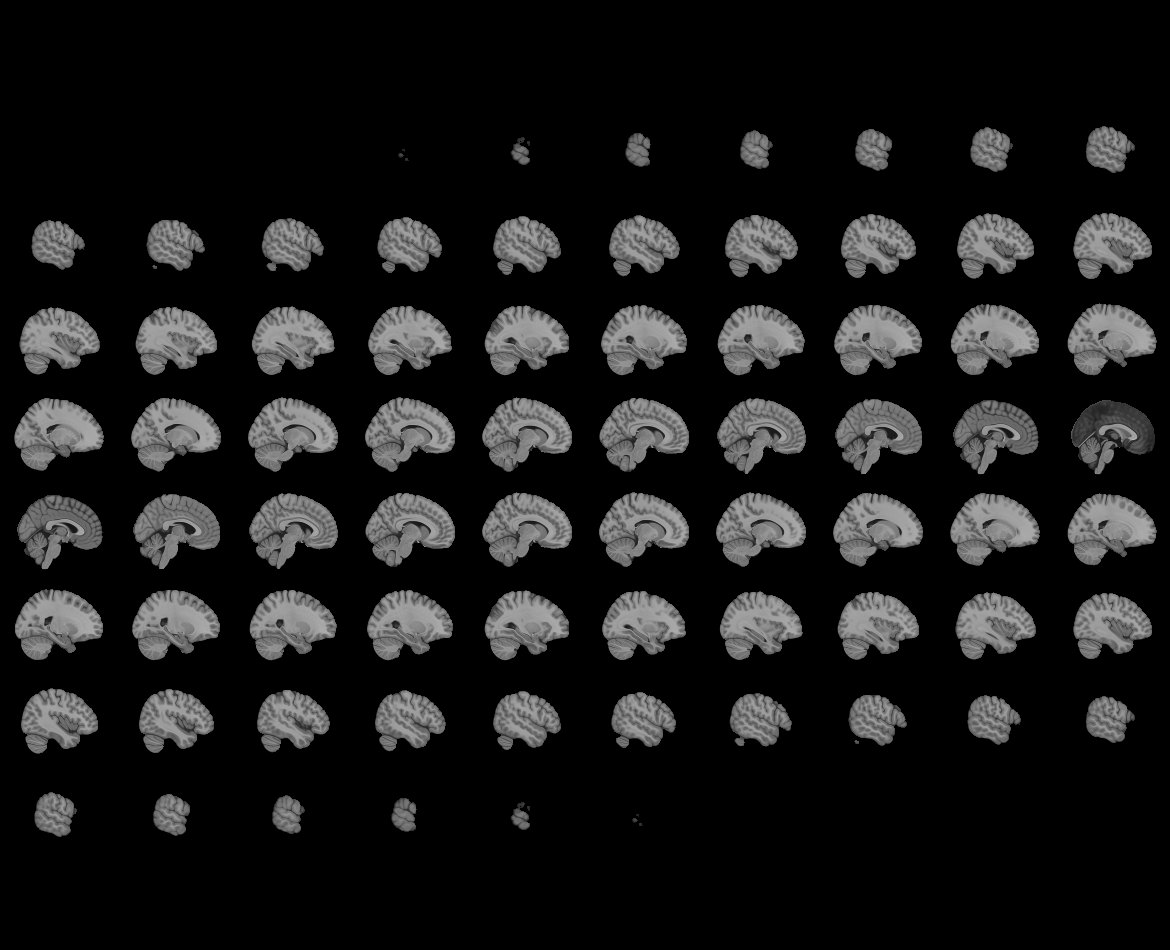
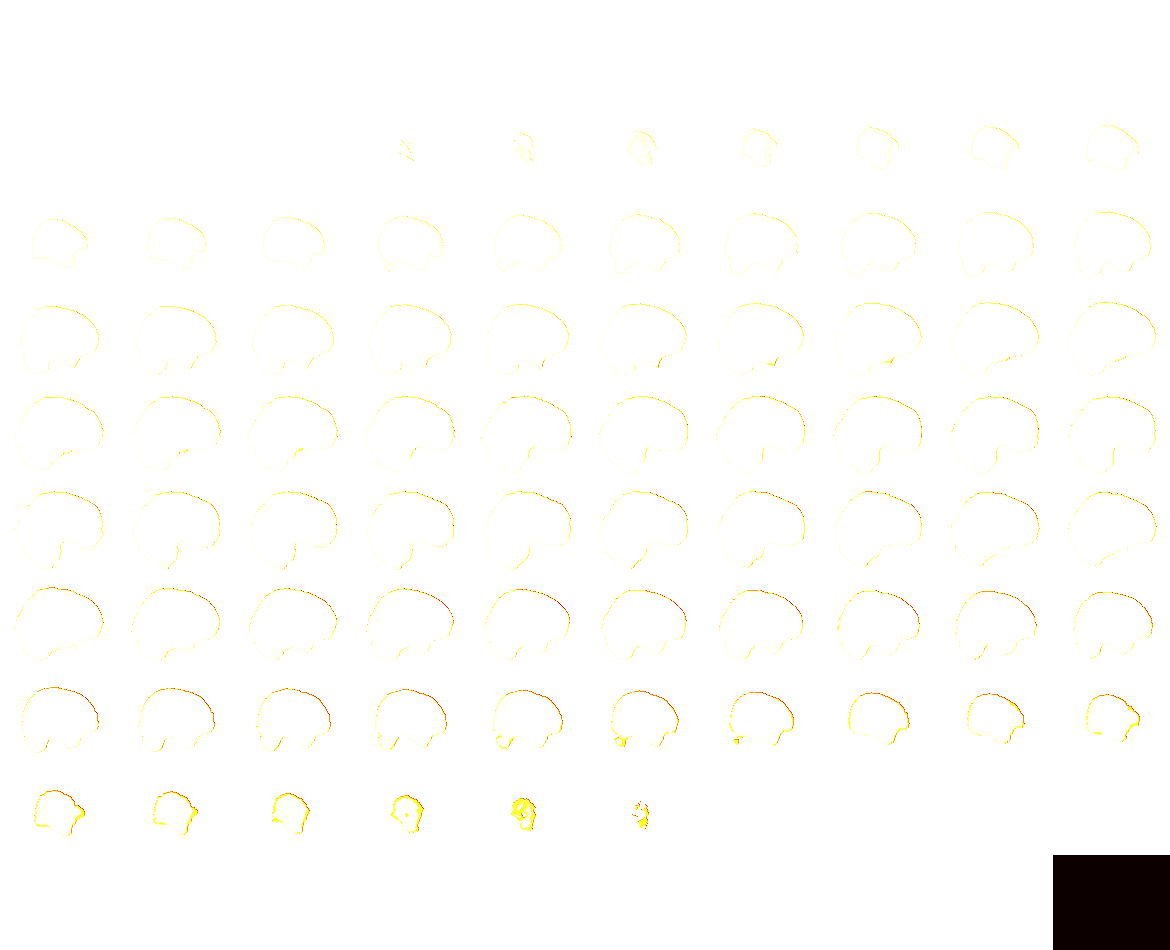

In [31]:

mask_name = f'/Users/demidenm/Desktop/patrick_dense/analysis/results/n-{len(file_list)}_mask.nii.gz'
if os.path.exists(mask_name):
    print("mask exists")
else:
    bin_imgs = [image.math_img("img != 0", img=image.load_img(file_path)) for file_path in file_list]
    intersection_binned_masks = masking.intersect_masks(bin_imgs, threshold=1.0)  
    intersection_binned_masks.to_filename(mask_name)
    
plotting.view_img(mask_name)

In [ ]:
for task in task_list:
        for con in efa_cons[task]:
            fixedeff_paths = glob(f'{inp_maps}/{task}/contrast_estimates/*_task-{task}_{con}_rtmodel-rt_centered_stat-fixed-effects_effect.nii.gz')
            # Create design matrix with intercept (1s) that's length of subjects/length of fixed_files
            n_maps = len(fixedeff_paths)
            design_matrix = pd.DataFrame([1] * n_maps, columns=['int'])
            sec_lvl_model = SecondLevelModel(mask_img=mask_name, smoothing_fwhm=None, minimize_memory=False)
            sec_lvl_model = sec_lvl_model.fit(second_level_input=fixedeff_paths, design_matrix=design_matrix)
            tstat_map = sec_lvl_model.compute_contrast(
                second_level_contrast='int',
                second_level_stat_type='t',
                output_type='stat'
            )
            tstat_out = f'{inp_maps}/{task}/contrast_estimates/subs-{n_maps}_task-{task}_{con}_rtmodel-rt_centered_stat-tstat.nii.gz'
            tstat_map.to_filename(tstat_out)

# Extract ROIs & Fit EFA

The focus of these analysea re on a subject of the total contrasts and tasks. This is to reduce the problem space and see how the between-parcel task and contrast activation is represented across the brain.

Below is a subset of contrasts being piloted. Per Patrick, the hypothesized structure may be:

### Working Memory/Updating
- `directedForgetting`: "contrast-neg-con"
- `nBack`: "contrast-twoBack-oneBack"

### Resist Distraction
- `flanker`: "contrast-incongruent - congruent"
- `shapeMatching`: "contrast-main_vars"

### Response Inhibition
- `goNogo`: "contrast-nogo_success-go"
- `stopSignal`: "contrast-stop_success-go"

### Task/Set Switching
- `spatialTS`: "contrast-task_switch_cue_switch-task_stay_cue_stay"
- `cuedTS`: "contrast-task_switch_cue_switch-task_stay_cue_stay"

---

The hypothesized model is:

**Sub factors**

Working_Memory_Updating =~ directedForgetting + nBack

Resist_Distraction =~ flanker + shapeMatching

Response_Inhibition =~ goNogo + stopSignal

Task_Set_Switching =~ spatialTS + cuedTS

**Overall factors**

Distraction_Control =~ Resist_Distraction + Response_Inhibition

Switching_Updating_Control =~ Working_Memory_Updating + Task_Set_Switching

The contrasts for the EFA are below. Note, for the subject specifc models we only estimate the EFA across the feature space. We do the same for the group-level (subejct average) and also test the propose two factor structure CFA. 

In [9]:
inp_maps = '/Users/demidenm/Desktop/patrick_dense/task_maps'
unique_subs = set(sub[0] for sub in sub_list)

data = {}
filepaths = []
ordered_col_names = []

for sub in unique_subs:
    data[sub] = {}  
    for task in task_list:
        for con in efa_cons[task]:
            file_path = f'{inp_maps}/{task}/contrast_estimates/{sub}_task-{task}_{con}_rtmodel-rt_centered_stat-fixed-effects_effect.nii.gz'
            
            if os.path.exists(file_path):
                data[sub][f"{task}_{con}"] = 1
                filepaths.append(file_path)
                col_name = f"{sub}_{task}_{con}"
                ordered_col_names.append(col_name)
            else:
                data[sub][f"{task}_{con}"] = 0

file_check_df = pd.DataFrame.from_dict(data, orient='index')
print("All",len(unique_subs),"subjects have each contrasts for each task ==", file_check_df.eq(1).all().all())

All 5 subjects have each contrasts for each task == True


In [2]:
# fetch and fit DIFUMO atlas. 
nodes = 1024
difumo = fetch_atlas_difumo(dimension=nodes,resolution_mm=2, legacy_format=False)
masker = NiftiMapsMasker(
    maps_img=difumo.maps,
    allow_overlap=True,
    standardize=False,
    resampling_target='data'
).fit()

In [10]:
for sub in unique_subs:
    sub_paths = [path for path in filepaths if sub in path]
    print("Subject:",sub, "has", len(sub_paths),"file path across tasks/contrasts that exist")
    out_file = f'/Users/demidenm/Downloads/{sub}_roi_df.csv'
    if os.path.exists(out_file):
        subroi_df = pd.read_csv(out_file, sep=',')
    else:
        # run nifti masker & reshape to row = ROI ~ column = Task/Contrast
        imgdata = [masker.transform(i) for i in sub_paths]
        print("     subject data array is:", np.array(imgdata).shape)
        reshaped_imgdata = np.array(imgdata).reshape(len(sub_paths), 1024)
        reshaped_imgdata = reshaped_imgdata.T
        columns = [f"Map_{i+1}" for i in range(reshaped_imgdata.shape[1])]
        
        # Convert to DataFrame for easier handling and saving
        subroi_df = pd.DataFrame(reshaped_imgdata, columns=columns)
        
        # Save to CSV file
        subroi_df.to_csv(out_file, sep=',', index=False)

Subject: sub-s10 has 28 file path across tasks/contrasts that exist


NameError: name 'masker' is not defined

/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


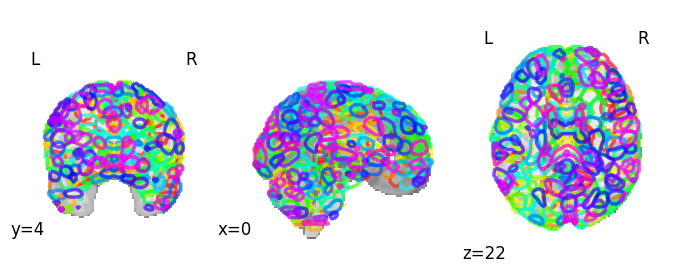

In [3]:
plotting.plot_prob_atlas(difumo.maps, draw_cross=False)

For EFA/CFA using [factor_analyzer](https://github.com/EducationalTestingService/factor_analyzer) and [documentation](https://factor-analyzer.readthedocs.io/en/latest/factor_analyzer.html). Of note, not a big fan of the package. Are there others that are useful for EFA/CFA in python? Specifically, I dont like the fact that the CFA doesnt provide any way to get the fit statistics and fit more complicated models. lavaan in R is far more powerful and useful...

# Parallel Analysis Results

Subject: sub-s10 has 28 file path across tasks/contrasts that exist
Parallel analysis suggests that the number of factors =  7  and the number of components =  6 


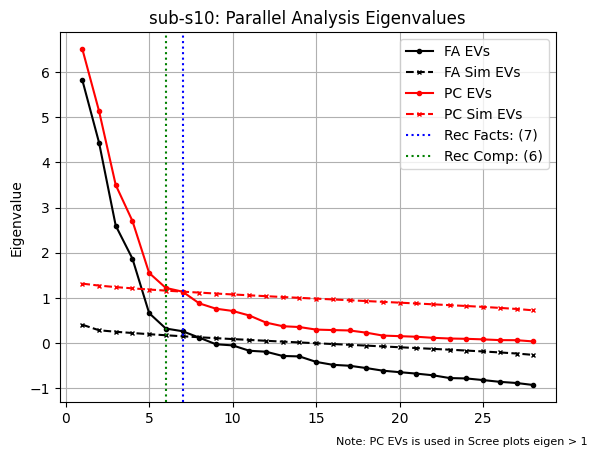

Subject: sub-s19 has 28 file path across tasks/contrasts that exist
Parallel analysis suggests that the number of factors =  8  and the number of components =  7 


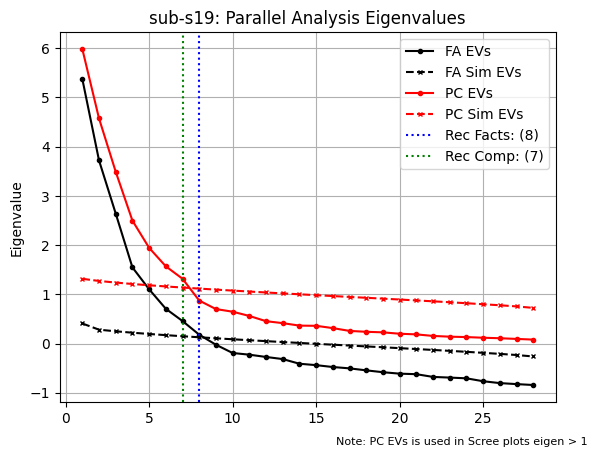

Subject: sub-s43 has 28 file path across tasks/contrasts that exist
Parallel analysis suggests that the number of factors =  6  and the number of components =  6 


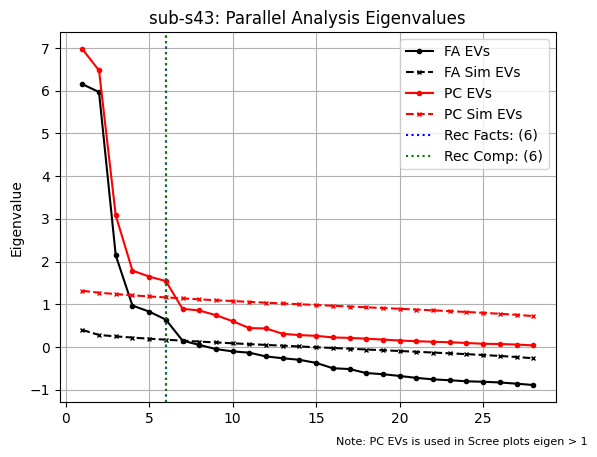

Subject: sub-s29 has 28 file path across tasks/contrasts that exist
Parallel analysis suggests that the number of factors =  7  and the number of components =  7 


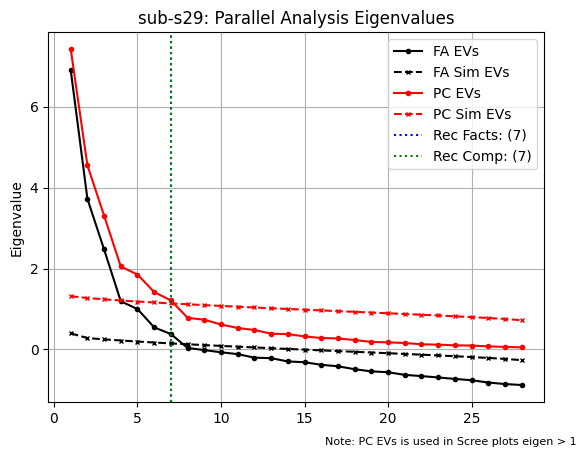

Subject: sub-s03 has 28 file path across tasks/contrasts that exist
Parallel analysis suggests that the number of factors =  6  and the number of components =  6 


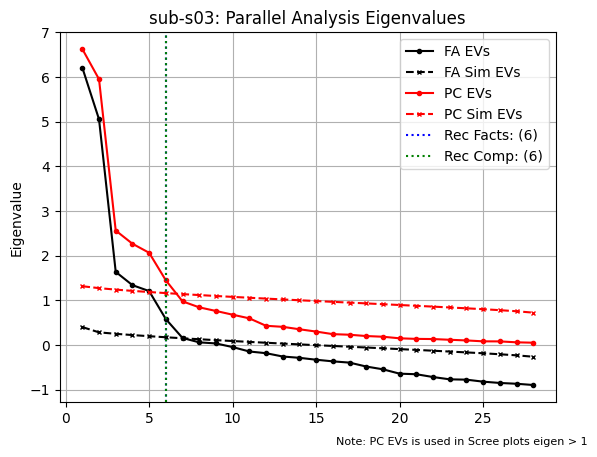

In [11]:
for sub in unique_subs:
    # after upgrade to python 3.11 for horns running into matploblib deprication warning
    from matplotlib import MatplotlibDeprecationWarning
    warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)


    sub_paths = [path for path in filepaths if sub in path]
    print("Subject:",sub, "has", len(sub_paths),"file path across tasks/contrasts that exist")
    roi_df_path = f'/Users/demidenm/Desktop/patrick_dense/analysis/results/{sub}_{len(sub_paths)}items.csv'
    if os.path.exists(roi_df_path):
        subroi_df = pd.read_csv(roi_df_path, sep=',')
    else:
        # run nifti masker & reshape to row = ROI ~ column = Task/Contrast
        imgdata = [masker.transform(i) for i in sub_paths]
        print("     subject data array is:", np.array(imgdata).shape)
        reshaped_imgdata = np.array(imgdata).reshape(len(sub_paths), 1024)
        reshaped_imgdata = reshaped_imgdata.T
        subdf_cols = [item for item in ordered_col_names if isinstance(item, str) and item.startswith(sub)]

        # create df using subset ordered columns (e.g. paths are ordered)
        subroi_df = pd.DataFrame(reshaped_imgdata, columns=subdf_cols)
        subroi_df.to_csv(roi_df_path,
                        sep=',', index=False)
        
    r_df = pandas2ri.py2rpy(subroi_df)
    
    # run corr and save results
    corr_matrix = subroi_df.corr()
    # Plot 1: Correlation Matrix Heatmap
    sns.heatmap(
        corr_matrix, 
        cmap='coolwarm', 
        vmin=-1, vmax=1,  
        linewidths=0.5,
        xticklabels=corr_matrix.columns,  
        yticklabels=corr_matrix.columns   
    )
    plt.title("Correlation Matrix")
    plt.xticks(rotation=45, ha='right') 
    plt.yticks(rotation=0)    
    plt.tight_layout()           
    plt.savefig(f'/Users/demidenm/Desktop/patrick_dense/analysis/results/{sub}_cormat.png')
    plt.close()  

    # Plot 2: Horn's parallel Analysis
    out_parallel = psych.fa_parallel(r_df, fm="ml", fa="both", n_iter=1000, show_legend=True, plot=True)
    plot_fa_parallel(out_parallel, title_name=sub, out_img_path=f'/Users/demidenm/Desktop/patrick_dense/analysis/results/{sub}_recfacts-{int(out_parallel[6])}.png')
    

# SUBJECT Factor Loadings & Phi Matrix

Subject: sub-s10 has 28 file path across tasks/contrasts that exist
Subject: * sub-s10 * 
	 Global Fit. 
 	 RMSEA: 0.14 (lower: 0.13, upper: 0.14) 
 	 CFI: 0.85 & BIC: 2766.64


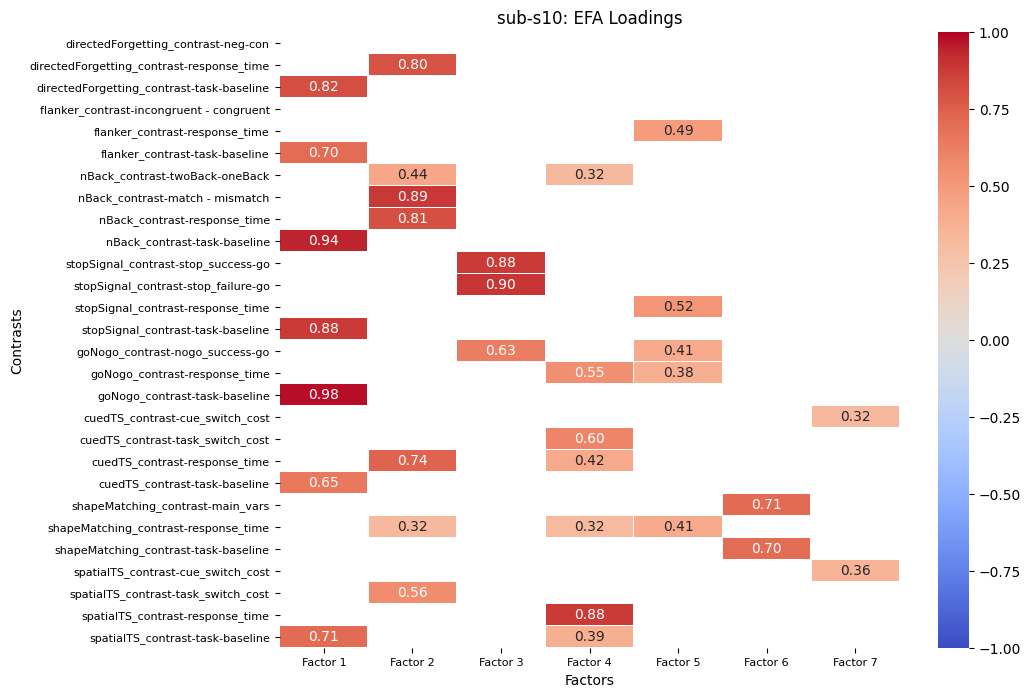

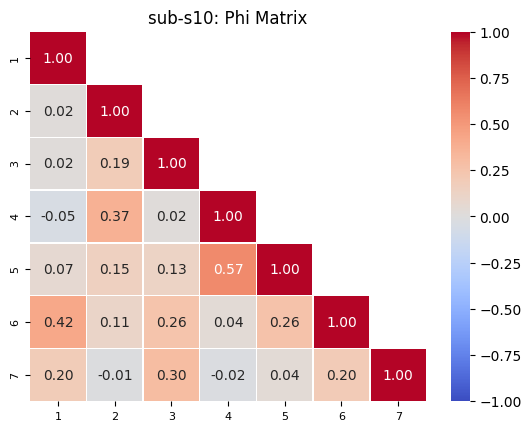

Subject: sub-s19 has 28 file path across tasks/contrasts that exist
Subject: * sub-s19 * 
	 Global Fit. 
 	 RMSEA: 0.12 (lower: 0.12, upper: 0.13) 
 	 CFI: 0.85 & BIC: 2023.62


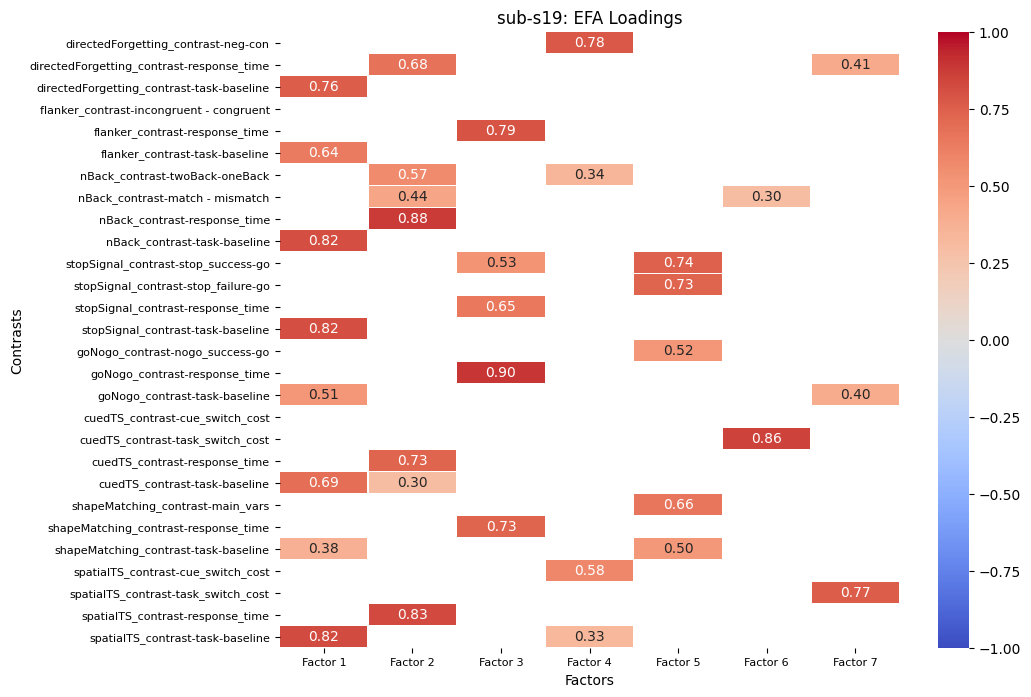

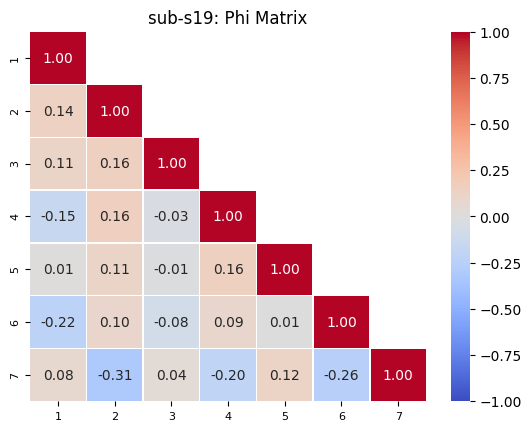

Subject: sub-s43 has 28 file path across tasks/contrasts that exist
Subject: * sub-s43 * 
	 Global Fit. 
 	 RMSEA: 0.13 (lower: 0.12, upper: 0.13) 
 	 CFI: 0.88 & BIC: 2196.39


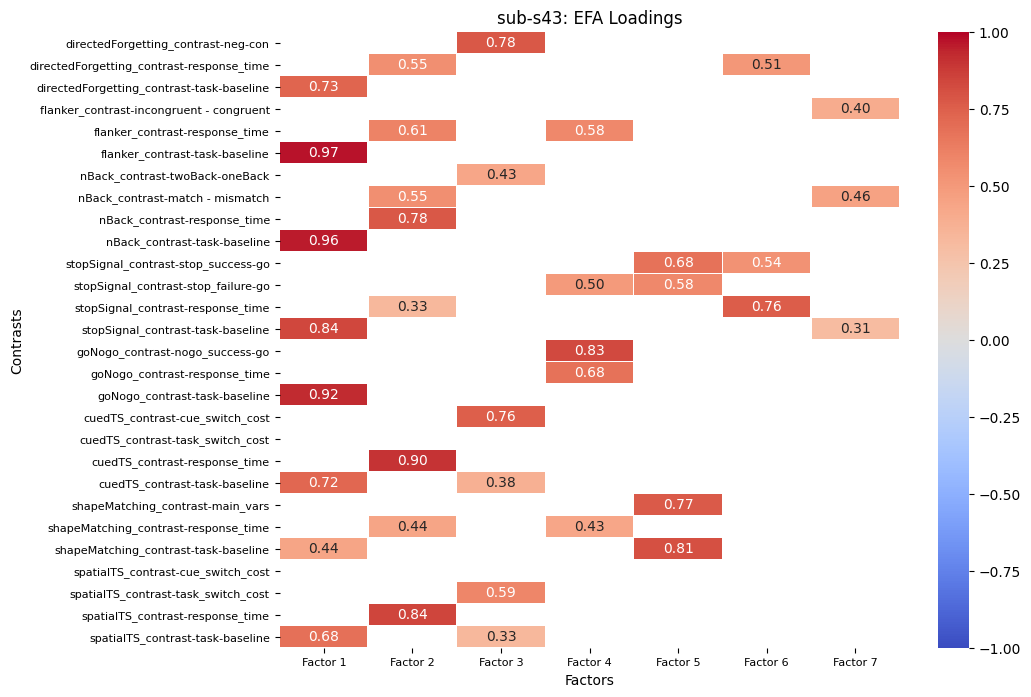

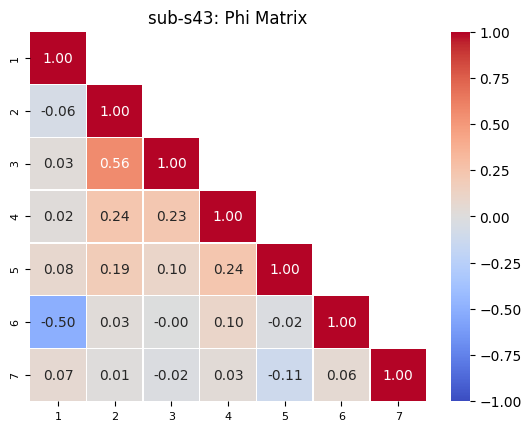

Subject: sub-s29 has 28 file path across tasks/contrasts that exist
Subject: * sub-s29 * 
	 Global Fit. 
 	 RMSEA: 0.13 (lower: 0.13, upper: 0.13) 
 	 CFI: 0.86 & BIC: 2374.59


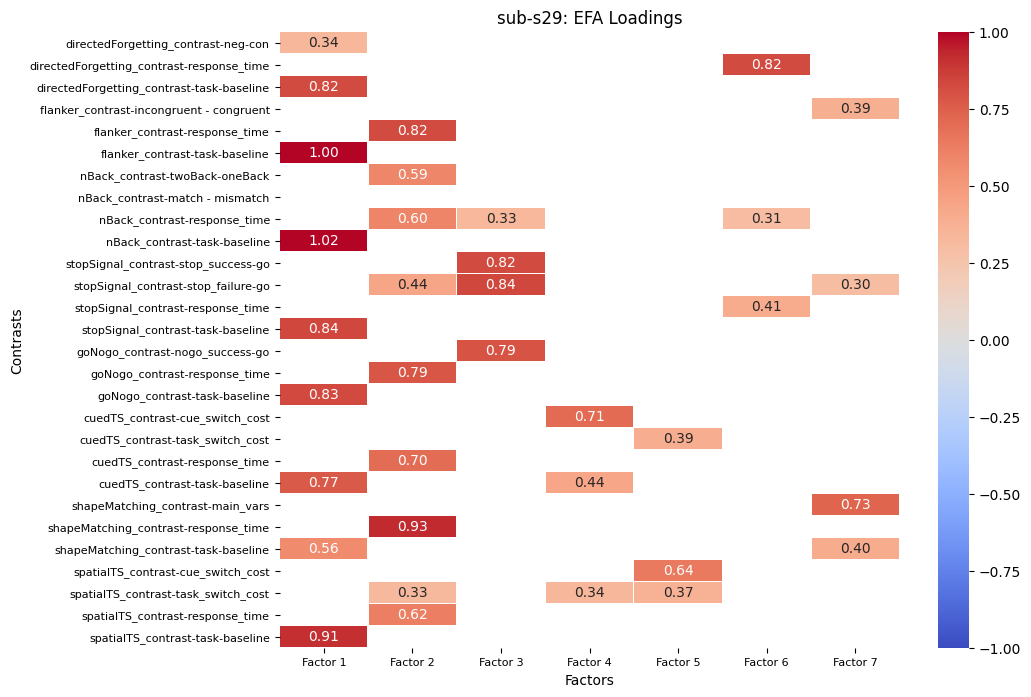

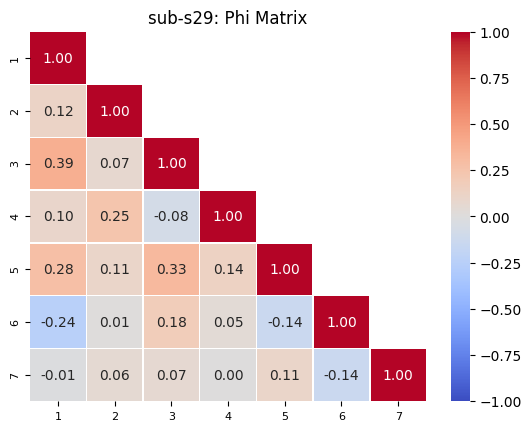

Subject: sub-s03 has 28 file path across tasks/contrasts that exist
Subject: * sub-s03 * 
	 Global Fit. 
 	 RMSEA: 0.13 (lower: 0.12, upper: 0.13) 
 	 CFI: 0.87 & BIC: 2121.18


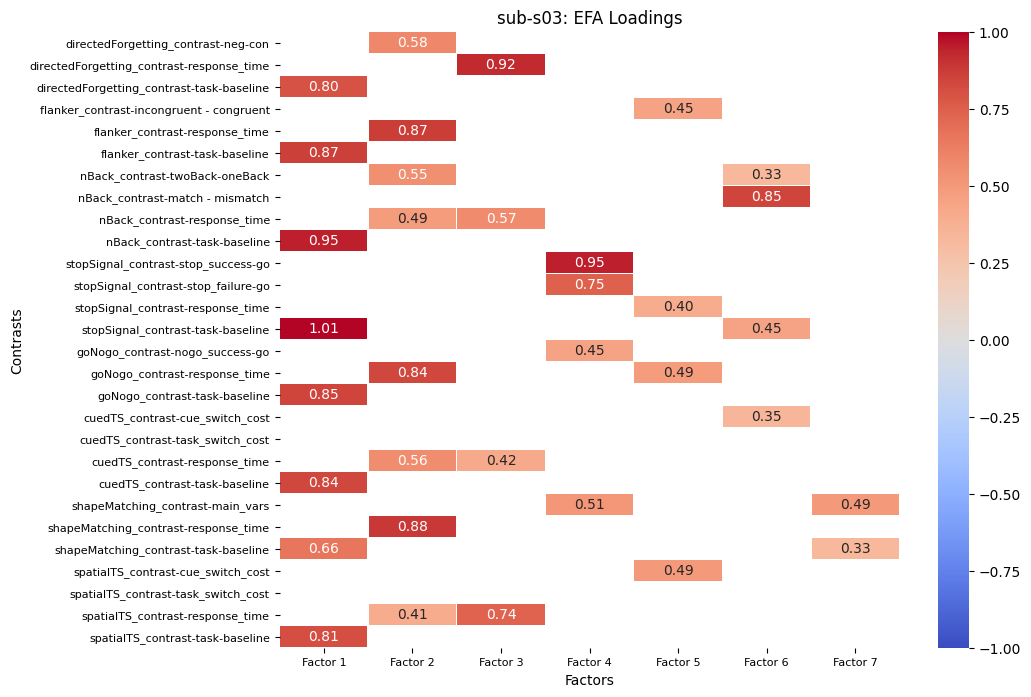

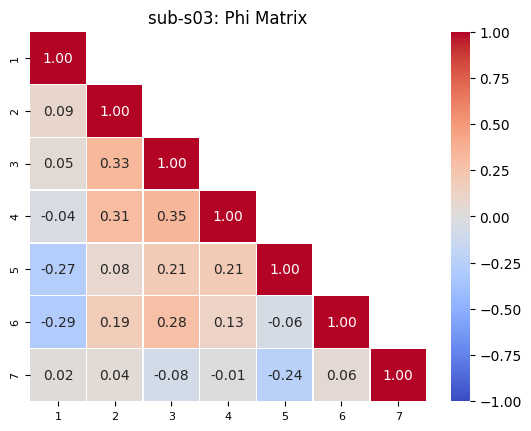

In [12]:
set_factor_n = 7

for sub in unique_subs:
    # after upgrade to python 3.11 for horns running into matploblib deprication warning
    from matplotlib import MatplotlibDeprecationWarning
    warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)


    sub_paths = [path for path in filepaths if sub in path]
    print("Subject:",sub, "has", len(sub_paths),"file path across tasks/contrasts that exist")
    roi_df_path = f'/Users/demidenm/Desktop/patrick_dense/analysis/results/{sub}_{len(sub_paths)}items.csv'
    if os.path.exists(roi_df_path):
        subroi_df = pd.read_csv(roi_df_path, sep=',')
    else:
        # run nifti masker & reshape to row = ROI ~ column = Task/Contrast
        imgdata = [masker.transform(i) for i in sub_paths]
        print("     subject data array is:", np.array(imgdata).shape)
        reshaped_imgdata = np.array(imgdata).reshape(len(sub_paths), 1024)
        reshaped_imgdata = reshaped_imgdata.T
        subdf_cols = [item for item in ordered_col_names if isinstance(item, str) and item.startswith(sub)]

        # create df using subset ordered columns (e.g. paths are ordered)
        subroi_df = pd.DataFrame(reshaped_imgdata, columns=subdf_cols)
        subroi_df.to_csv(roi_df_path,
                        sep=',', index=False)
        
    r_df = pandas2ri.py2rpy(subroi_df)

    # Plot 1: EFA Loadings Heatmap
    fa = psych.fa(r_df, fm = "ml", rotate="promax", nfactors=set_factor_n, scores = 'Bartlett')
    print_fit_stats(label=sub,model_obj=fa)
    plot_loading_phi(fa_object=fa, title_name=sub, out_type='loadings' ,
                     row_labs=subroi_df.columns, out_img_path=f'/Users/demidenm/Desktop/patrick_dense/analysis/results/{sub}_efaloadings.png')


    # Plot 2: Phi Matrix (Factor Cosine/Corr)
    plot_loading_phi(fa_object=fa, title_name=sub, out_type='phi',phi_plot_diag=True, 
                     out_img_path=f'/Users/demidenm/Desktop/patrick_dense/analysis/results/{sub}_efa-phi.png')

# GROUP Factor Loadings & Phi Matrix

In [ ]:
group_paths = glob(f'{inp_maps}/**/contrast_estimates/subs-*')
grp_cols = [
'directedForgetting_contrast-neg-con',
'directedForgetting_contrast-response_time',
'directedForgetting_contrast-task-baseline',
'flanker_contrast-incongruent - congruent',
'flanker_contrast-response_time',
'flanker_contrast-task-baseline',
'nBack_contrast-twoBack-oneBack',
'nBack_contrast-match - mismatch',
'nBack_contrast-response_time',
'nBack_contrast-task-baseline',
'stopSignal_contrast-stop_success-go',
'stopSignal_contrast-stop_failure-go',
'stopSignal_contrast-response_time',
'stopSignal_contrast-task-baseline',
'goNogo_contrast-nogo_success-go',
'goNogo_contrast-response_time',
'goNogo_contrast-task-baseline',
'cuedTS_contrast-task_switch_cost',
'cuedTS_contrast-cue_switch_cost',
'cuedTS_contrast-response_time',
'cuedTS_contrast-task-baseline',
'shapeMatching_contrast-main_vars',
'shapeMatching_contrast-response_time',
'shapeMatching_contrast-task-baseline',
'spatialTS_contrast-cue_switch_cost',
'spatialTS_contrast-task_switch_cost',
'spatialTS_contrast-response_time',
'spatialTS_contrast-task-baseline',
]

print("Total Group Maps:", len(group_paths), "across N contrast", len(grp_cols))


Total Group Maps: 28 across N contrast 28


Parallel analysis suggests that the number of factors =  7  and the number of components =  6 


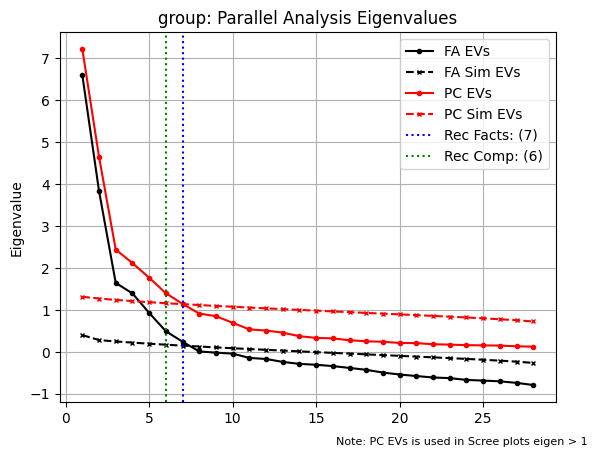

Subject: * group * 
	 Global Fit. 
 	 RMSEA: 0.08 (lower: 0.08, upper: 0.08) 
 	 CFI: 0.93 & BIC: 139.50


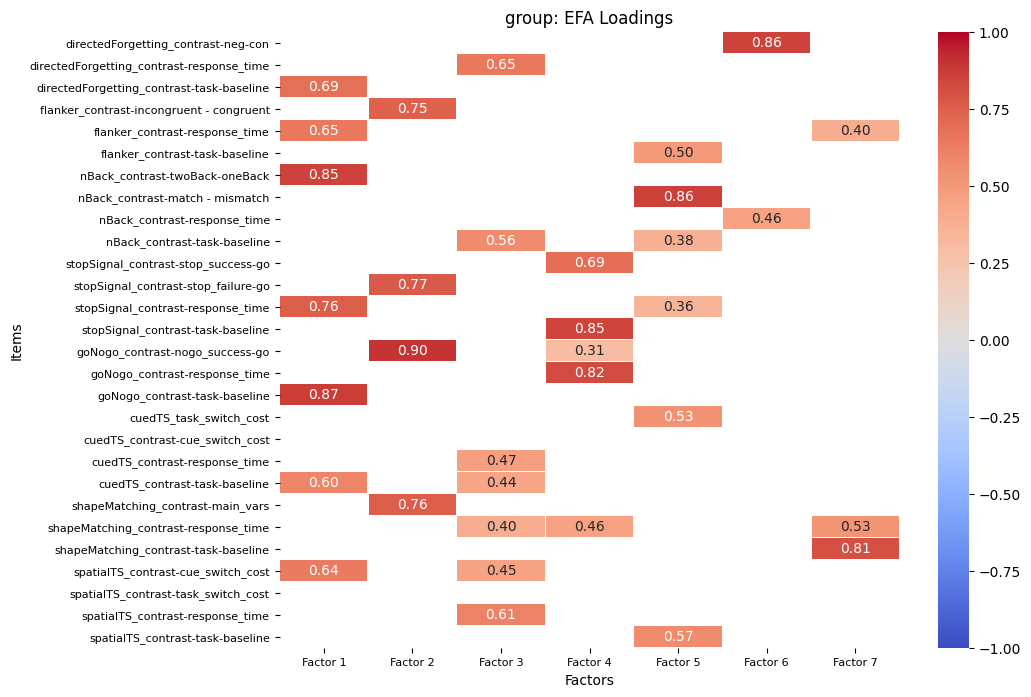

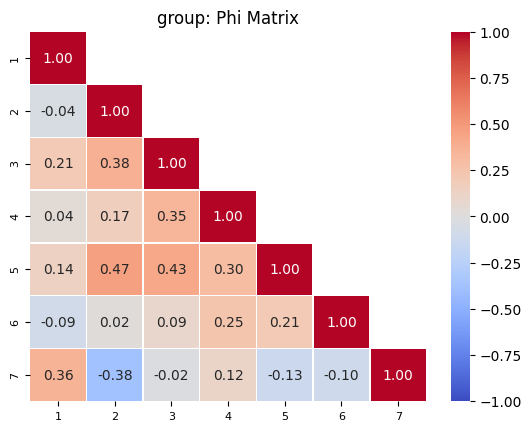

In [51]:
grp_out_path = f'/Users/demidenm/Desktop/patrick_dense/analysis/results/groups-subs_{len(group_paths)}items.csv'
if os.path.exists(grp_out_path):
    grp_df = pd.read_csv(grp_out_path, sep=',')
else:
    # run nifti masker & reshape to row = ROI ~ column = Task/Contrast
    imgdata = [masker.transform(i) for i in group_paths]
    print("     subject data array is:", np.array(imgdata).shape)
    reshaped_imgdata = np.array(imgdata).reshape(len(group_paths), 1024)
    reshaped_imgdata = reshaped_imgdata.T

    # create df using subset ordered columns (e.g. paths are ordered)
    grp_df = pd.DataFrame(reshaped_imgdata, columns=grp_cols)
    grp_df.to_csv(grp_out_path, sep=',', index=False)

# run corr and save results
corr_matrix = grp_df.corr()
# Plot 1: Correlation Matrix Heatmap
plt.figure(figsize=(12, 16))  
sns.heatmap(
    corr_matrix, 
    cmap='coolwarm', 
    vmin=-1, vmax=1, 
    linewidths=0.5,
    xticklabels=corr_matrix.columns,  
    yticklabels=corr_matrix.columns   
)
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)               
plt.savefig(f'/Users/demidenm/Desktop/patrick_dense/analysis/results/grp_cormat.png', bbox_inches='tight')
plt.close()  
 
# Plot 2: Horn's parallel Analysis
r_df = pandas2ri.py2rpy(grp_df)

out_parallel = psych.fa_parallel(r_df, fm="ml", fa="both", n_iter=1000, show_legend=True, plot=True)
plot_fa_parallel(out_parallel, title_name='group', out_img_path=f'/Users/demidenm/Desktop/patrick_dense/analysis/results/grp_recfacts-{int(out_parallel[6])}.png')

# Plot 3: EFA Loadings Heatmap
fa = psych.fa(r_df, fm = "ml", rotate="promax", nfactors=set_factor_n, scores = 'Bartlett')
print_fit_stats(label='group',model_obj=fa)
plot_loading_phi(fa_object=fa, title_name='group', out_type='loadings' ,
                    row_labs=grp_cols, out_img_path=f'/Users/demidenm/Desktop/patrick_dense/analysis/results/grp_efaloadings.png')


# Plot 2: Phi Matrix (Factor Cosine/Corr)
plot_loading_phi(fa_object=fa, title_name='group', out_type='phi',phi_plot_diag=True, 
                    out_img_path=f'/Users/demidenm/Desktop/patrick_dense/analysis/results/grp_efa-phi.png')



# Reverse Transform Factor (Bartlett) Scores

In [7]:
keys = list(['sub-s19', 'sub-s29', 'sub-s43', 'sub-s10', 'sub-s03','groups-subs'])


results_dict = {}
for sub in keys:
    df_path = f'/Users/demidenm/Desktop/patrick_dense/analysis/results/{sub}_28items.csv' 
    roi_df = pd.read_csv(df_path, sep=',')
    r_df = pandas2ri.py2rpy(roi_df) 
    fa = psych.fa(r_df, fm = "ml", rotate="promax", nfactors=7, scores = 'Bartlett')
    bartlett_scores = np.array(fa.rx2('scores'))
    
    subject_factors = {}

    for factor_index in range(np.array(bartlett_scores).shape[-1]):
        factor = factor_index+1
        # Access all scores for the current factor
        factor_scores = bartlett_scores[:, factor_index]
        brain_scores = masker.inverse_transform(np.array(factor_scores))
        subject_factors[factor] = brain_scores
        brain_scores.to_filename(f'/Users/demidenm/Desktop/patrick_dense/analysis/results/{sub}_factor-{factor}_barlett-scores.nii.gz')
    results_dict[sub] = subject_factors



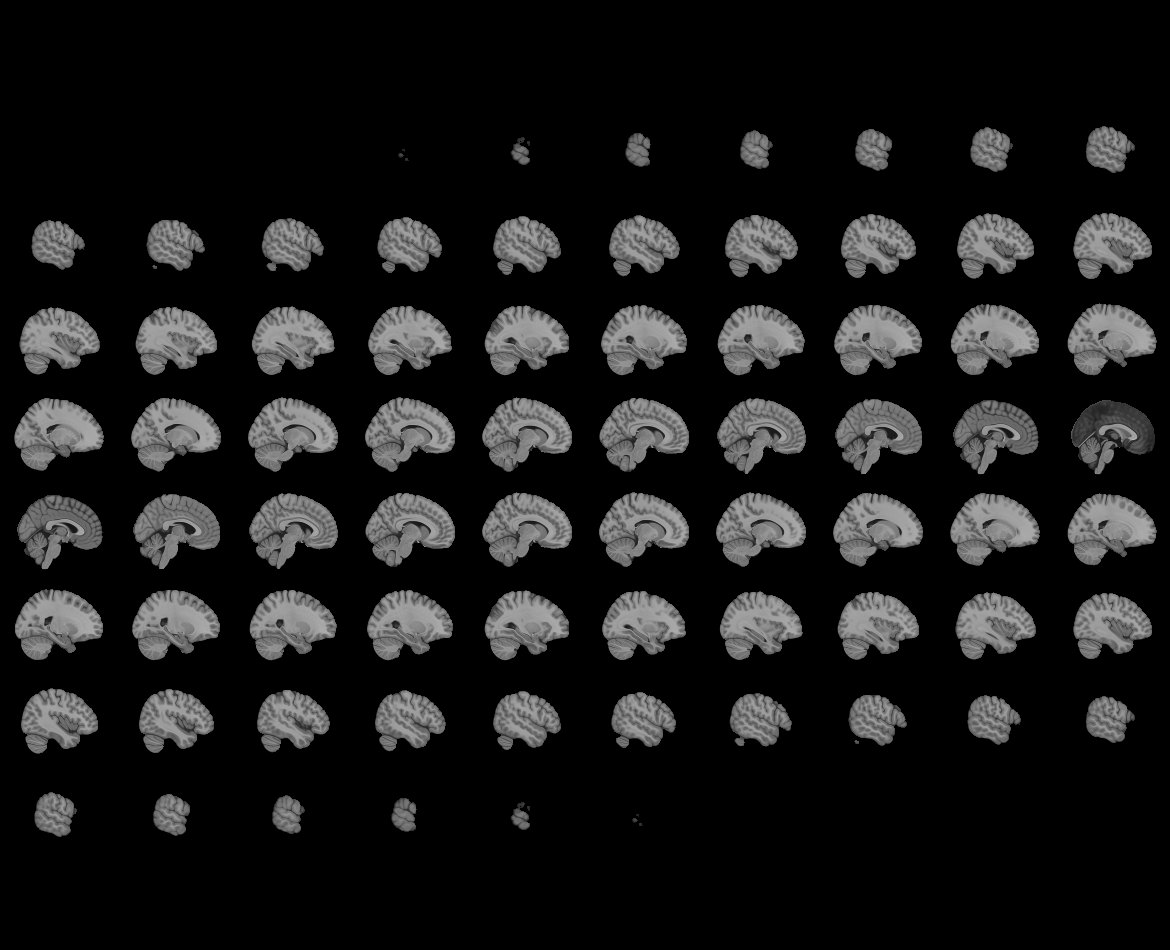
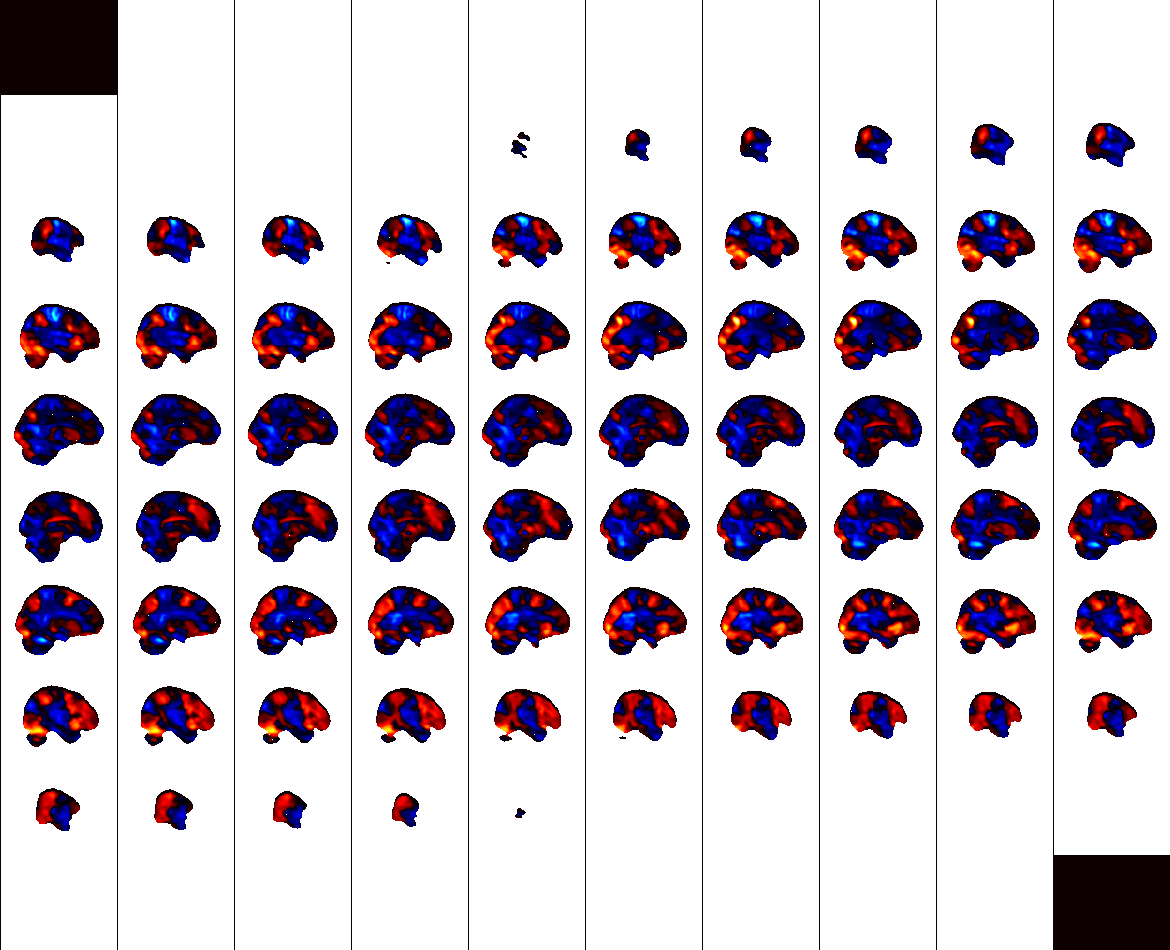

In [28]:
factor_n=4
plotting.view_img(results_dict['groups-subs'][factor_n], title=f"Factor {factor_n}", cut_coords=(26,-40,18))

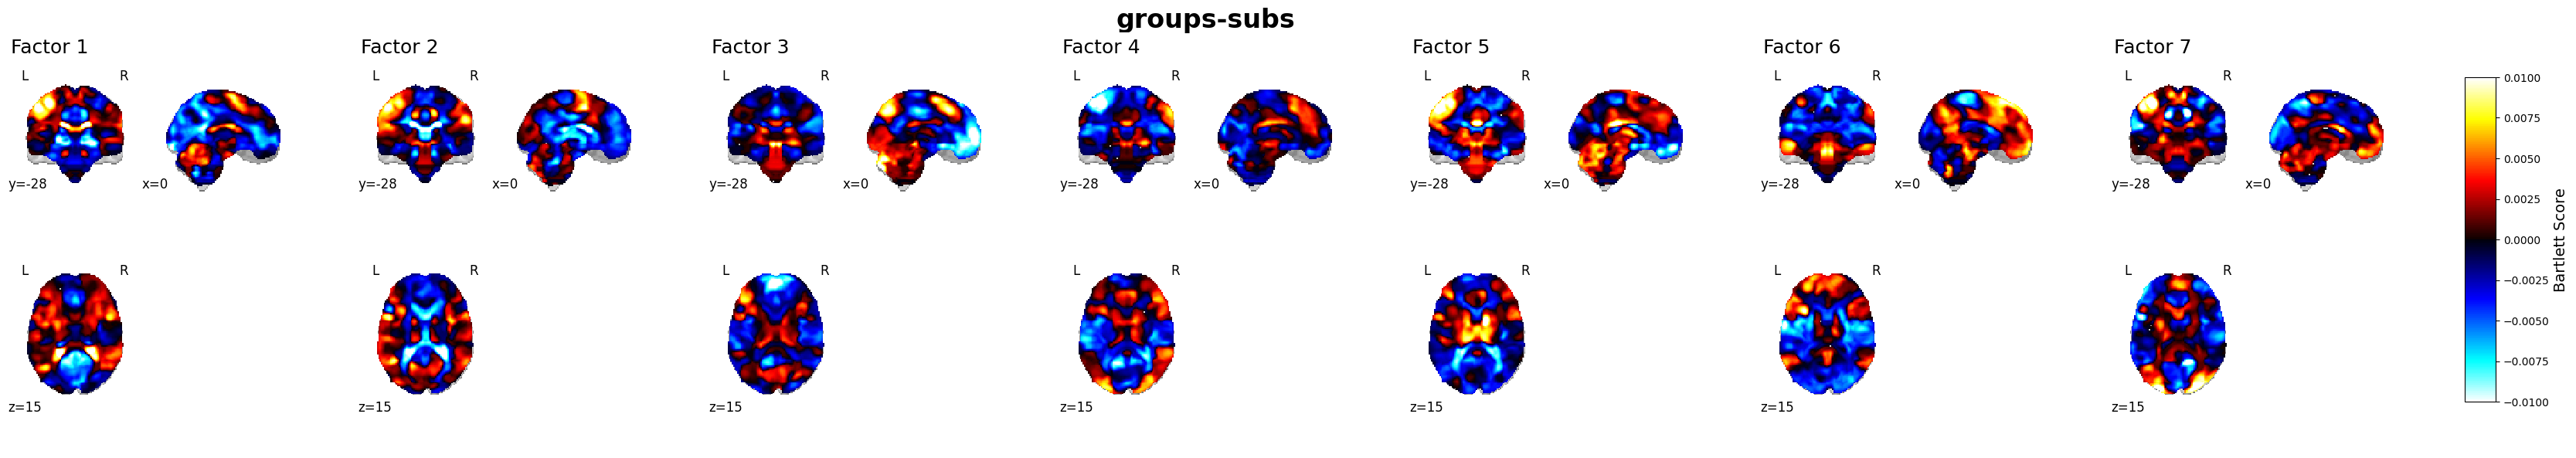

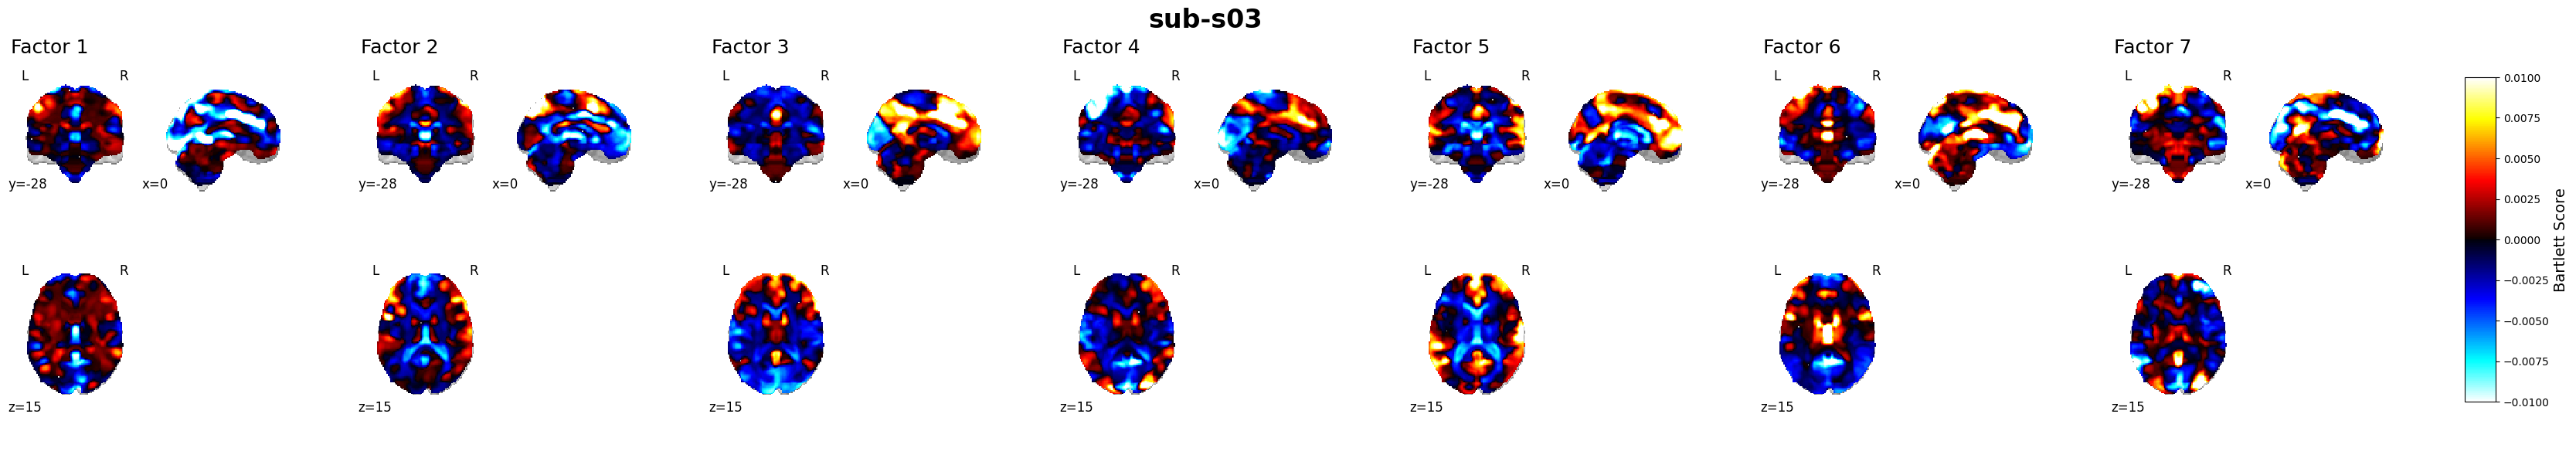

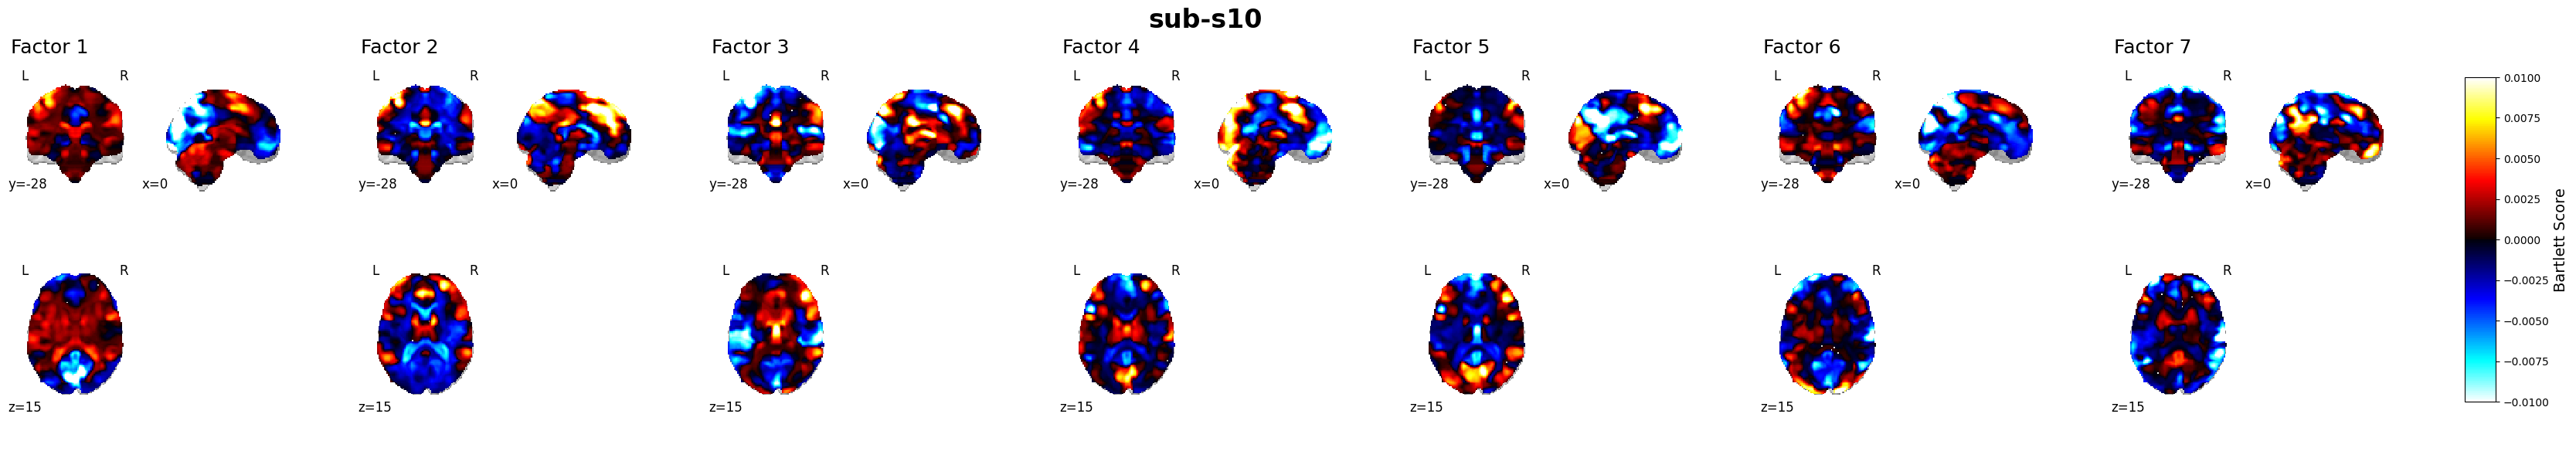

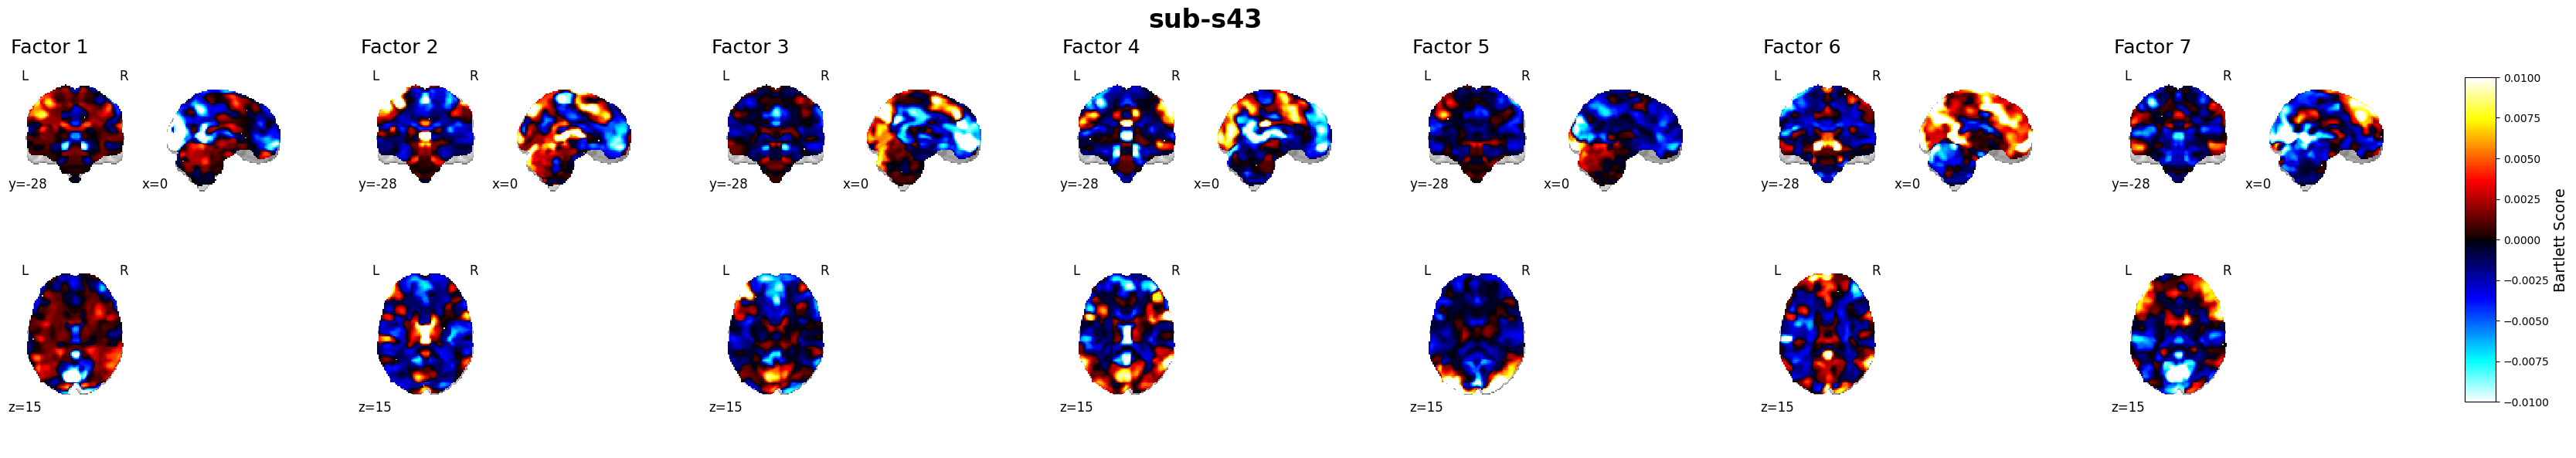

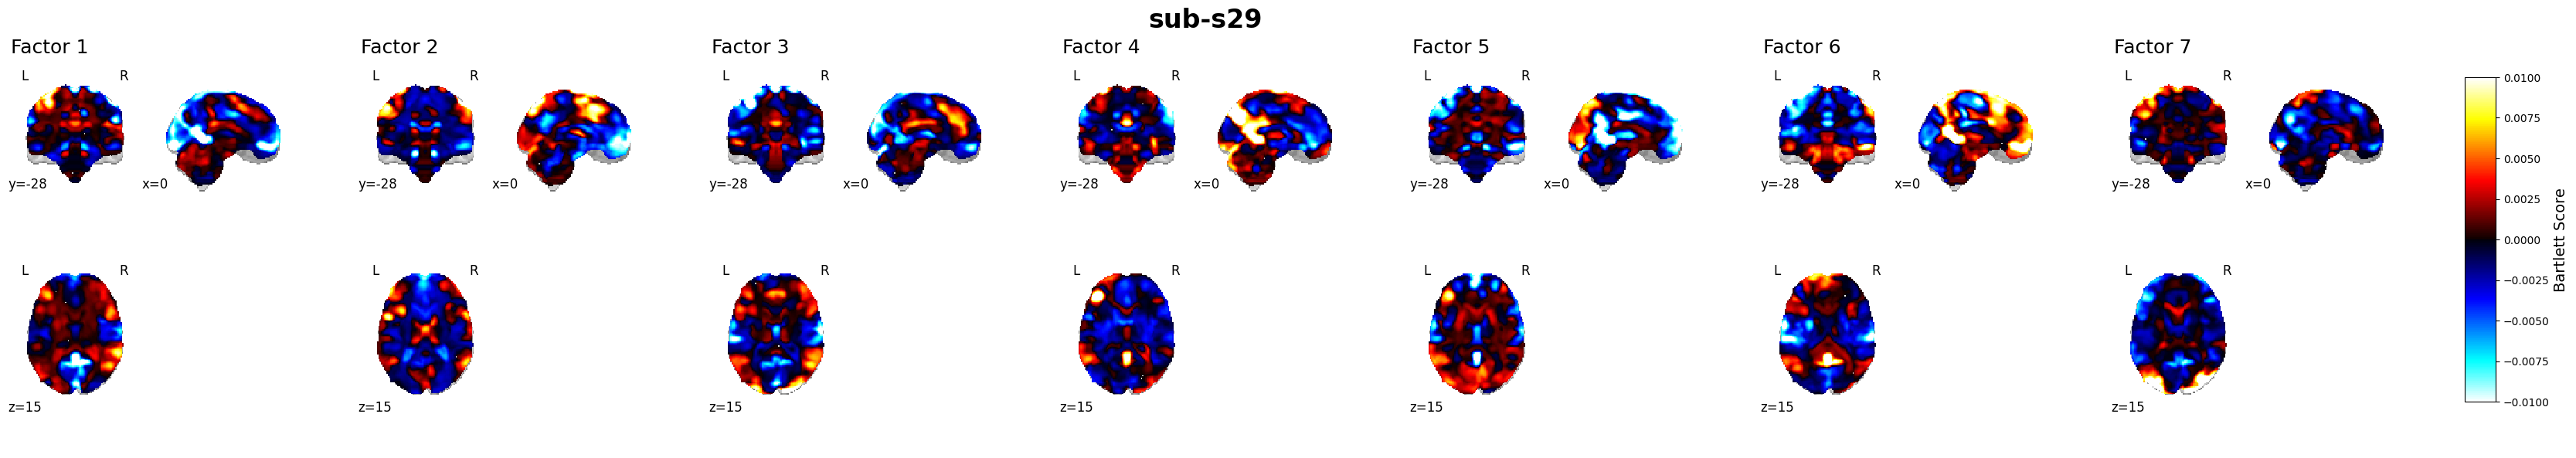

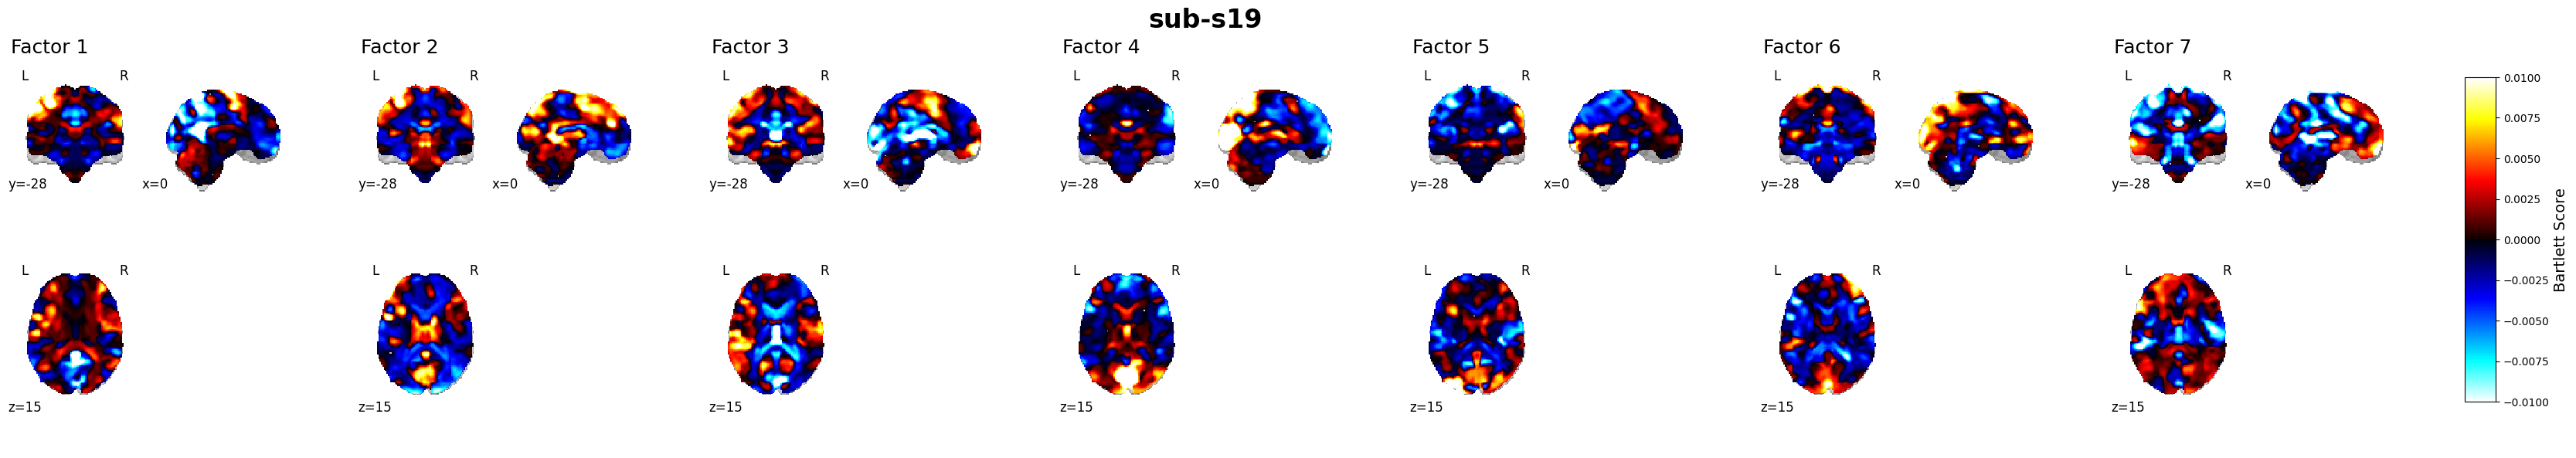

In [37]:
n_factors = len(results_dict[next(iter(results_dict))])

# loop over each subject + factor
for i,subject in enumerate(reversed(results_dict.keys())):
    fig, axes = plt.subplots(1, n_factors, figsize=(40, 7))
    axes[3].set_title(subject, fontsize=24, weight='bold')

    for f, factor in enumerate(results_dict[next(iter(results_dict))]):
        fig_name = f"{factor}"  


        display = plotting.plot_stat_map(
            stat_map_img=results_dict[subject][factor],
            display_mode="tiled",
            cut_coords=(0,-28,15),
            title=fig_name,  
            draw_cross=False,
            colorbar=False,
            vmax = 0.01,
            axes=axes[f]  
        )
        display.title(f"Factor {fig_name}", size=18, color='black', bgcolor='white', alpha=1)
    cbar_ax = fig.add_axes([0.92, 0.2, 0.01, .6])  # adjust x, y, width, height
    norm = plt.Normalize(vmin=-.01, vmax=.01)  # update min/max for intensity
    cbar = mpl_colorbar.ColorbarBase(cbar_ax, cmap=plt.get_cmap('cold_hot'), norm=norm) 
    cbar.set_label("Bartlett Score", fontsize=14)
    plt.show()
    

# CFA (Ignore for now, as intend to use R)

For CFA, we can run solution if three items are provided for each of the three factors. However, in this case we only have two items per so we will work on a 2 factor solution across the items for illustration purposes.

**Sub factors**

Working_Memory_Updating =~ directedForgetting + nBack

Resist_Distraction =~ flanker + shapeMatching

Response_Inhibition =~ goNogo + stopSignal

Task_Set_Switching =~ spatialTS + cuedTS

**Overall factors**

Distraction_Control =~ Resist_Distraction + Response_Inhibition

Switching_Updating_Control =~ Working_Memory_Updating + Task_Set_Switching

In [ ]:
group_data_file = pd.read_csv(f'/Users/demidenm/Desktop/patrick_dense/analysis/results/groups-subs_{len(group_paths)}items.csv', sep=',')
group_data_file.columns,len(group_paths)

**Below CFA model was preliminary attempt in Python. Not good option. CFA via lavaan in R is superior**

In [ ]:
cog_model = {
    "WM_Update": ["nBack_contrast-twoBack-oneBack", "directedForgetting_contrast-neg-con", "shapeMatching_contrast-main_vars", "spatialTS_contrast-task_switch_cue_switch-task_stay_cue_stay"], 
    "Res_DistInh": ["flanker_contrast-incongruent - congruent_rtmodel", "shapeMatching_contrast-main_vars", "goNogo_contrast-nogo_success-go", "stopSignal_contrast-stop_success-go"],
    "Res_Inh": ["goNogo_contrast-nogo_success-go", "stopSignal_contrast-stop_success-go", "flanker_contrast-incongruent - congruent_rtmodel"],

}

modelsvars = ['nBack_contrast-twoBack-oneBack',
 'directedForgetting_contrast-neg-con',
 'shapeMatching_contrast-main_vars',
 'spatialTS_contrast-task_switch_cue_switch-task_stay_cue_stay',
 'flanker_contrast-incongruent - congruent_rtmodel',
 'goNogo_contrast-nogo_success-go',
 'stopSignal_contrast-stop_success-go']

model_spec = ModelSpecificationParser.parse_model_specification_from_dict(group_data_file, cog_model)
cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=True) 
cfa.fit(group_data_file[modelsvars].values) 

## Factor Congruence (**IGNORE FOR NOW, PRETTY OFF FROM MY R CODE**)

Note, the below is attempting the calculate the same matrix as in `fa.congruence` in R, however, the results dont appear to align. Need to take a look at the code and formulate to understand the discrepancy.

In [ ]:
in_dir = f'/Users/demidenm/Desktop/patrick_dense/analysis/results'
fa_results = {}
for file in [os.path.basename(i) for i in glob(f'{in_dir}/*items.csv')]:
    df_type = file.split('_')[0]
    df_inp = pd.read_csv(f'{in_dir}/{file}', sep=',')
    corr_matrix = df_inp.corr()
    fa = FactorAnalyzer(n_factors=4, rotation='promax')  
    fa.fit(df_inp.values)
    loadings = fa.loadings_
    fa_results[df_type] = loadings

In [ ]:
keys = list(['sub-s19', 'sub-s29', 'sub-s43', 'sub-s10', 'sub-s03','groups-subs'])
combinations = list(itertools.combinations(keys, 2))

fig, axes = plt.subplots(nrows=len(combinations)//3, ncols=3, figsize=(25, len(combinations)*2.5))
axes = axes.flatten() 

for i, (key1, key2) in enumerate(combinations):
    congruence_matrix = np.tril(np.squeeze(factor_congruence(fa_results[key1], fa_results[key2])))  # Keep only the lower triangle

    ax = axes[i]
    sns.heatmap(congruence_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, 
                ax=ax, square=True, linewidths=0.5, annot_kws={"size": 8})
    
    ax.set_title(f'Congruence: {key1} ~ {key2}')
    ax.set_xticks(range(congruence_matrix.shape[1]))
    ax.set_yticks(range(congruence_matrix.shape[0]))
    ax.set_xticklabels([f'F{i+1}' for i in range(congruence_matrix.shape[1])])
    ax.set_yticklabels([f'F{i+1}' for i in range(congruence_matrix.shape[0])])

plt.tight_layout()
plt.show()

In [ ]:
keys = list(['sub-s19', 'sub-s29', 'sub-s43', 'sub-s10', 'sub-s03','groups-subs'])
n_keys = len(keys)
n_factors = fa_results[keys[0]].shape[1]  

# full matrix
big_matrix = np.full((n_keys * n_factors, n_keys * n_factors), np.nan)

for i, (key1, key2) in enumerate(itertools.combinations(keys, 2)):
    fa1, fa2 = fa_results[key1], fa_results[key2]
    congruence_matrix = np.squeeze(factor_congruence(fa1, fa2))  # lower triangle only

    idx1 = keys.index(key1) * n_factors
    idx2 = keys.index(key2) * n_factors
    big_matrix[idx1:idx1 + n_factors, idx2:idx2 + n_factors] = congruence_matrix
    big_matrix[idx2:idx2 + n_factors, idx1:idx1 + n_factors] = congruence_matrix.T  # symmetric

# Create labels for the large matrix
factor_labels = [f'{key}_F{i+1}' for key in keys for i in range(n_factors)]

plt.figure(figsize=(10, 8))
sns.heatmap(big_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            xticklabels=factor_labels, yticklabels=factor_labels,
            cbar_kws={'label': 'Congruence'})
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Pairwise Factor Congruence Matrix")
plt.tight_layout()
plt.show()

In [5]:
pub_med = pd.read_csv('~/Desktop/Academia/Stanford/9_ResearchSci/Grants/NOSI_RDoC/Figures/precision-neuroscience_year.csv', sep=',')
pub_med

Year  precision neuroscience
0   2010                0.000000
1   2011                0.000000
2   2012                0.000000
3   2013                0.000000
4   2014                0.000000
5   2015                0.000000
6   2016                0.000000
7   2017                0.076663
8   2018                0.000000
9   2019                0.140971
10  2020                0.060919
11  2021                0.447468
12  2022                0.954433
13  2023                1.770262
14  2024                1.330418

No handles with labels found to put in legend.


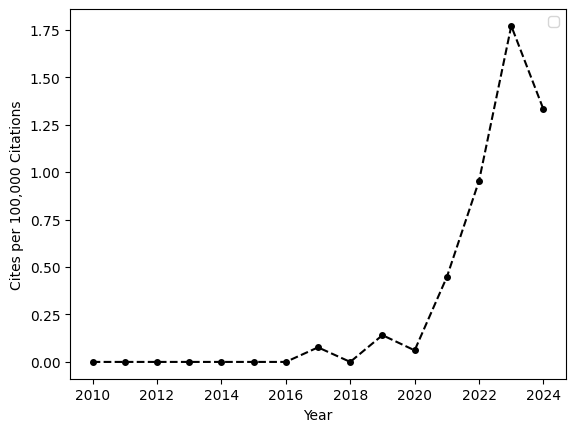

In [13]:
plt.plot(pub_med['Year'].values, pub_med['precision neuroscience'].values, 
         label='', 
         color='black', 
         marker='o', 
         linestyle='--', 
         markersize=4)

plt.xlabel('Year')  
plt.ylabel('Cites per 100,000 Citations')  
plt.title('')  
plt.legend()  
plt.show()